In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.optimize

from datetime import datetime
import pytz

import trfp

central_time = pytz.timezone('US/Central')

matplotlib.rc('xtick', labelsize=10)     
matplotlib.rc('ytick', labelsize=10)
matplotlib.rc('axes', titlesize=16)
matplotlib.rc('axes', labelsize=12)
plt.rcParams["font.family"] = "serif"
sns.set(style="darkgrid")

Welcome to JupyROOT 6.12/04


In [2]:
station_phi = trfp.STATION_BARCODE_PHI
station_edges = trfp.STATION_BARCODE_EDGES

corrected_df_1 = pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3956_corrected_df')
tr_baseline_1, fp_baseline_1, baseline_time_1, summed_azimuth_1, _ = trfp.trolley_run_station_average(corrected_df_1)

corrected_df_2 = pd.read_hdf('60hr_trolley_runs_2.h5', key='run_3997_corrected_df')
tr_baseline_2, fp_baseline_2, baseline_time_2, summed_azimuth_2, _ = trfp.trolley_run_station_average(corrected_df_2)

# load all fixed probe runs moment_df into one big moment_df (runs 3959--3994)
fp_moment_df = pd.read_hdf('60hr_fixed_probe_runs.h5', key='run_3959_moment_df')
pts = fp_moment_df.shape[0]
for run in np.arange(3959, 3995):
    temp_df = pd.read_hdf('60hr_fixed_probe_runs.h5', key='run_'+str(run)+'_moment_df')
    pts = pts + temp_df.shape[0]
    print '\rAppending run ' + str(run) + '.',
    fp_moment_df = fp_moment_df.append(temp_df)

# load all the trolley runs corrected_df into on big file (to show window of 60hr set) ()
tr_corrected_df = pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3955_corrected_df')
for run in np.arange(3956, 3959):
    temp_df = pd.read_hdf('60hr_trolley_runs_1.h5', key='run_'+str(run)+'_corrected_df')
    pts = pts + temp_df.shape[0]
    print '\rAppending run ' + str(run) + '.',
    tr_corrected_df = tr_corrected_df.append(temp_df)
for run in np.arange(3995, 3999):
    temp_df = pd.read_hdf('60hr_trolley_runs_2.h5', key='run_'+str(run)+'_corrected_df')
    pts = pts + temp_df.shape[0]
    print '\rAppending run ' + str(run) + '.',
    tr_corrected_df = tr_corrected_df.append(temp_df)

print '\rDone appending runs.',

Done appending runs.                                


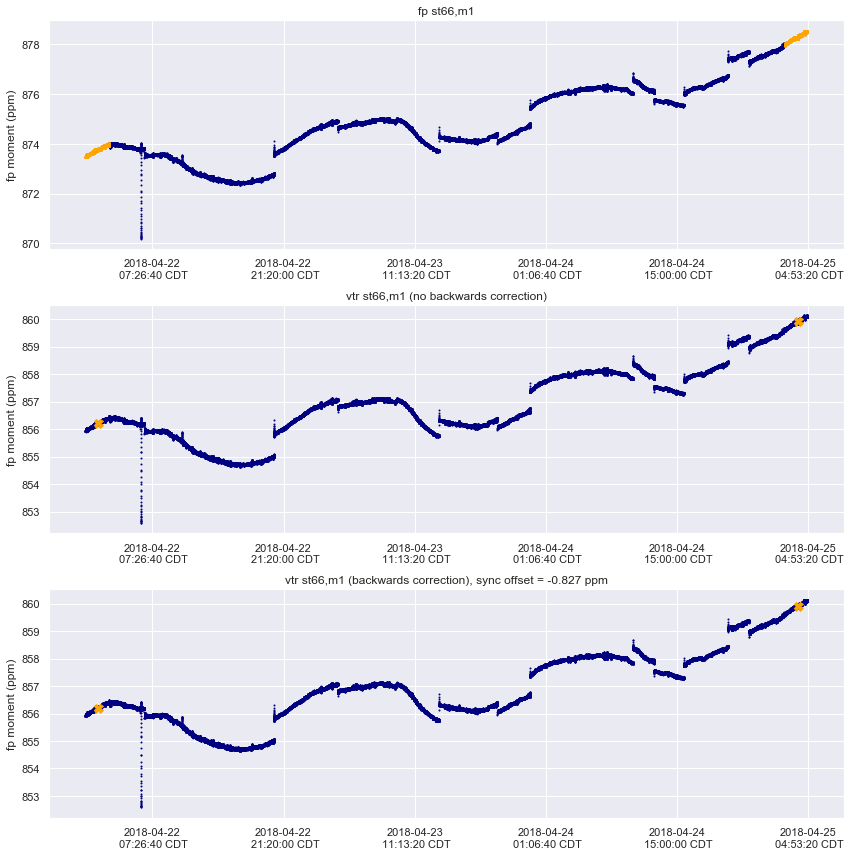

In [3]:
st = 66
m = 1
stm = 'st'+str(st)+',m'+str(m)

# apply baseline correction to chosen station

vtr_stm = tr_baseline_1[st, m-1] + (fp_moment_df[stm] - fp_baseline_1[st, m-1])
vtr_stm_tr_run =  tr_baseline_1[st, m-1] + (tr_corrected_df[stm] - fp_baseline_1[st, m-1])

# apply backwards correction to chosen station

def backwards_correction(time):
    c1 = tr_baseline_1[st, m-1] - fp_baseline_1[st, m-1]
    c2 = tr_baseline_2[st, m-1] - fp_baseline_2[st, m-1]
    t1 = baseline_time_1[st]
    t2 = baseline_time_2[st]
    return (c2-c1)/(t2-t1)*(time-t1) + c1

vtr_stm = fp_moment_df[stm] + backwards_correction(fp_moment_df.index.values)
vtr_stm_tr_run = tr_corrected_df[stm] + backwards_correction(tr_corrected_df.index.values)
glitch = backwards_correction(baseline_time_2[st]) - backwards_correction(baseline_time_1[st])


# make plots

fig, ax = plt.subplots(3,1)
plt.sca(ax[0])
plt.plot(fp_moment_df.index.values, fp_moment_df[stm]/61.79, '.', color='navy', markersize=2)
plt.plot(tr_corrected_df.index.values, tr_corrected_df[stm]/61.79, '.', color='orange', markersize=2)
xticks = ax[0].get_xticks()
ax[0].set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z')
                     for tm in xticks], rotation=0)
ax[0].set_ylabel('fp moment (ppm)')
ax[0].set_title('fp '+stm)

plt.sca(ax[1])
plt.plot(fp_moment_df.index.values, vtr_stm/61.79, '.', color='navy', markersize=2)
plt.plot(tr_corrected_df.index.values, vtr_stm_tr_run/61.79, '.', color='navy', markersize=2)
plt.plot(baseline_time_1[st], tr_baseline_1[st, m-1]/61.79, 'X', color='orange', markersize=9)
plt.plot(baseline_time_2[st], tr_baseline_2[st, m-1]/61.79, 'X', color='orange', markersize=9)
xticks = ax[1].get_xticks()
ax[1].set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z')
                     for tm in xticks], rotation=0)
ax[1].set_ylabel('fp moment (ppm)')
ax[1].set_title('vtr '+stm+' (no backwards correction)')

plt.sca(ax[2])
plt.plot(fp_moment_df.index.values, vtr_stm/61.79, '.', color='navy', markersize=2)
plt.plot(tr_corrected_df.index.values, vtr_stm_tr_run/61.79, '.', color='navy', markersize=2)
plt.plot(baseline_time_1[st], tr_baseline_1[st, m-1]/61.79, 'X', color='orange', markersize=9)
plt.plot(baseline_time_2[st], tr_baseline_2[st, m-1]/61.79, 'X', color='orange', markersize=9)
xticks = ax[2].get_xticks()
ax[2].set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z')
                     for tm in xticks], rotation=0)
ax[2].set_ylabel('fp moment (ppm)')
ax[2].set_title('vtr '+stm+' (backwards correction), sync offset = %.3f ppm'%(glitch/61.79))

fig.set_size_inches(12,12)
fig.tight_layout()

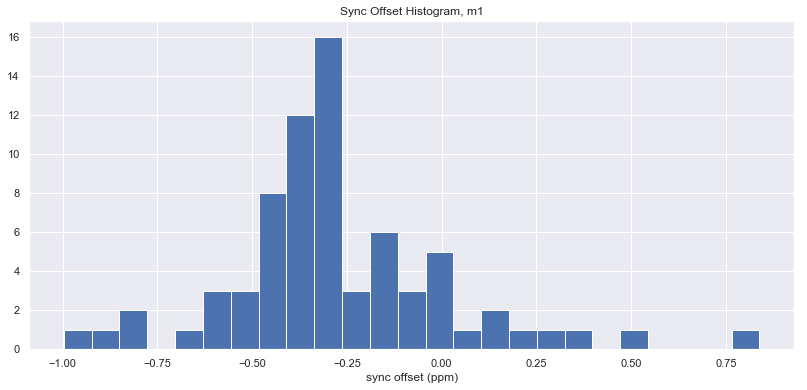

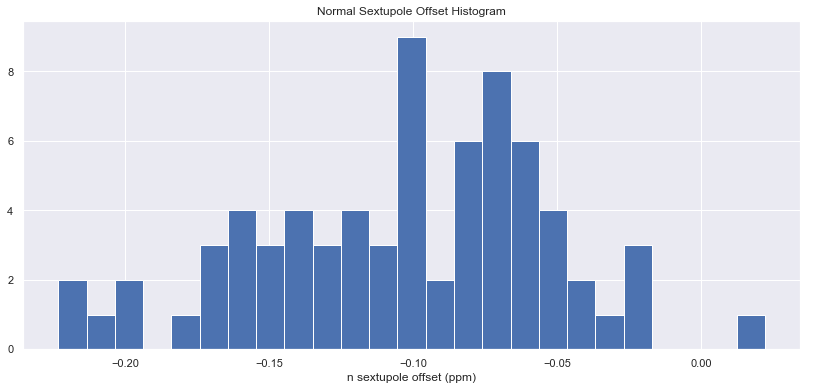

In [4]:
# analyze glitches

m=1

def backwards_correction_2(time):
    c1 = tr_baseline_1[:, m-1] - fp_baseline_1[:, m-1]
    c2 = tr_baseline_2[:, m-1] - fp_baseline_2[:, m-1]
    t1 = baseline_time_1[st]
    t2 = baseline_time_2[st]
    return (c2-c1)/(t2-t1)*(time-t1) + c1

glitches = backwards_correction_2(baseline_time_2) - backwards_correction_2(baseline_time_1)

glitch_hist_fig, glitch_hist_ax = plt.subplots(1,1)
plt.sca(glitch_hist_ax)
plt.hist(glitches/61.79, 25)
glitch_hist_ax.set_title('Sync Offset Histogram, m%.0f'%m)
glitch_hist_ax.set_xlabel('sync offset (ppm)')
glitch_hist_fig.tight_layout()
glitch_hist_fig.set_size_inches(12,6)

# check what happened to the normal 6-pole in this time
sextupole_fig, sextupole_ax = plt.subplots(1,1)
plt.sca(sextupole_ax)
plt.hist((tr_baseline_2[:,4] - tr_baseline_1[:,4])/61.79, 25)
sextupole_ax.set_title('Normal Sextupole Offset Histogram')
sextupole_ax.set_xlabel('n sextupole offset (ppm)')
sextupole_fig.tight_layout()
sextupole_fig.set_size_inches(12,6)

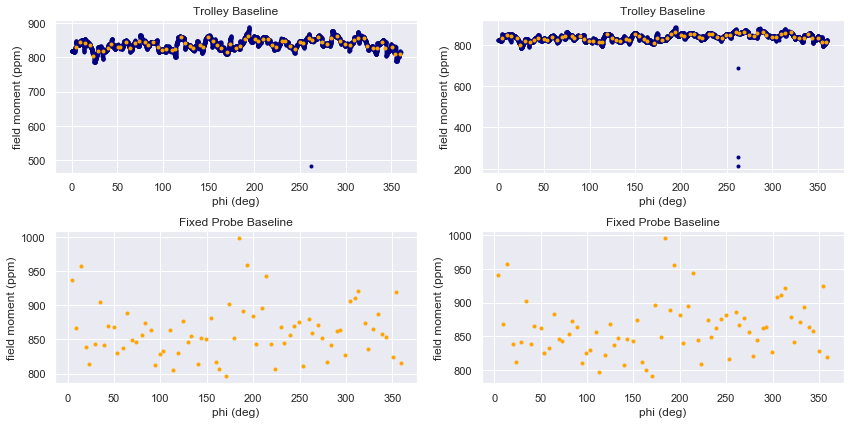

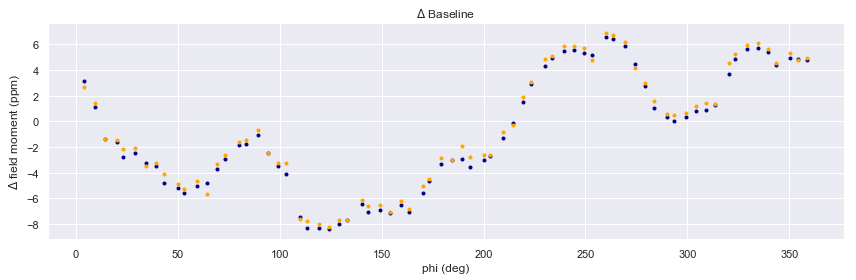

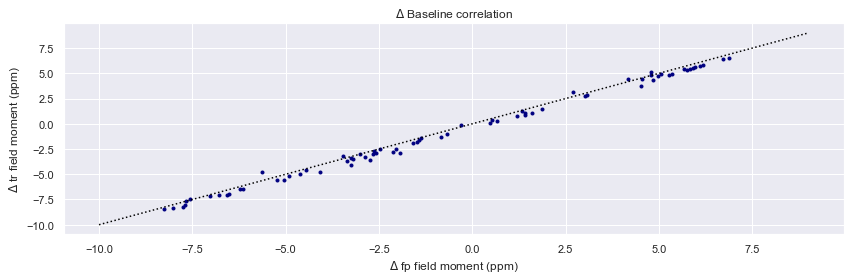

In [5]:
m = 1
trolley_moment = 'tr,m'+str(m)

fig2, ax2 = plt.subplots(2,2)

plt.sca(ax2[0,0])
plt.plot(corrected_df_1['tr_phi'],corrected_df_1[trolley_moment]/61.79, '.', color='navy')
plt.plot(station_phi, tr_baseline_1[:,m-1]/61.79, '.', color='orange', markersize=6)
ax2[0,0].set_xlabel('phi (deg)')
ax2[0,0].set_ylabel('field moment (ppm)')
ax2[0,0].set_title('Trolley Baseline')
plt.sca(ax2[1,0])
plt.plot(station_phi, fp_baseline_1[:,m-1]/61.79, '.', color='orange', markersize=6)
ax2[1,0].set_xlabel('phi (deg)')
ax2[1,0].set_ylabel('field moment (ppm)')
ax2[1,0].set_title('Fixed Probe Baseline')

plt.sca(ax2[0,1])
plt.plot(corrected_df_2['tr_phi'],corrected_df_2[trolley_moment]/61.79, '.', color='navy')
plt.plot(station_phi, tr_baseline_2[:,m-1]/61.79, '.', color='orange', markersize=6)
ax2[0,1].set_xlabel('phi (deg)')
ax2[0,1].set_ylabel('field moment (ppm)')
ax2[0,1].set_title('Trolley Baseline')
plt.sca(ax2[1,1])
plt.plot(station_phi, fp_baseline_2[:,m-1]/61.79, '.', color='orange', markersize=6)
ax2[1,1].set_xlabel('phi (deg)')
ax2[1,1].set_ylabel('field moment (ppm)')
ax2[1,1].set_title('Fixed Probe Baseline')

fig2.set_size_inches(12,6)
fig2.tight_layout()


fig5, ax5 = plt.subplots(1,1)
plt.sca(ax5)
plt.plot(station_phi, tr_baseline_2[:,m-1]/61.79 - tr_baseline_1[:,m-1]/61.79, '.', color='navy', markersize=6)
plt.plot(station_phi, fp_baseline_2[:,m-1]/61.79 - fp_baseline_1[:,m-1]/61.79, '.', color='orange', markersize=6)
ax5.set_xlabel('phi (deg)')
ax5.set_ylabel(r'$\Delta$ field moment (ppm)')
ax5.set_title(r'$\Delta$ Baseline')

fig5.set_size_inches(12,4)
fig5.tight_layout()


fig6, ax6 = plt.subplots(1,1)
plt.sca(ax6)
plt.plot(fp_baseline_2[:,m-1]/61.79 - fp_baseline_1[:,m-1]/61.79,
         tr_baseline_2[:,m-1]/61.79 - tr_baseline_1[:,m-1]/61.79, '.', color='navy', markersize=6)
plt.plot(np.arange(-10,10), np.arange(-10,10), ':', color='black')
ax6.set_xlabel(r'$\Delta$ fp field moment (ppm)')
ax6.set_ylabel(r'$\Delta$ tr field moment (ppm)')
ax6.set_title(r'$\Delta$ Baseline correlation')

fig6.set_size_inches(12,4)
fig6.tight_layout()

In [6]:
# calculate azimuthal averages as a function of time

# first thing to do is to create a virtual trolley measurement dataframe
vtr_df = fp_moment_df.copy()
# NOTE: FOR NOW THIS ONLY LOOKS AT M1--M3, STILL NEEDS UPDATED JACOBIAN
for st in np.arange(72):
    for m in np.arange(3):
        def backwards_correction(time):
            c1 = tr_baseline_1[st, m] - fp_baseline_1[st, m]
            c2 = tr_baseline_2[st, m] - fp_baseline_2[st, m]
            t1 = baseline_time_1[st]
            t2 = baseline_time_2[st]
            return (c2-c1)/(t2-t1)*(time-t1) + c1
        
        print '\rSyncing st'+str(st)+', m'+str(m+1),        
        
        stm = 'st'+str(st)+',m'+str(m+1)
        vtr_df[stm] = vtr_df[stm] + backwards_correction(fp_moment_df.index.values)

Syncing st71, m3


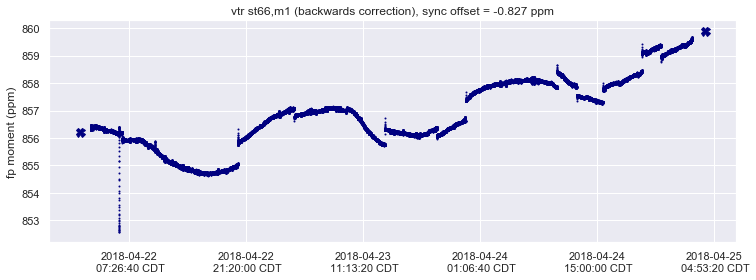

In [7]:
st = 66
m = 1
stm = 'st'+str(st)+',m'+str(m)

fig10, ax10 = plt.subplots(1,1)
plt.sca(ax10)
plt.plot(fp_moment_df.index.values, vtr_df[stm]/61.79, '.', color='navy', markersize=2)
plt.plot(baseline_time_1[st], tr_baseline_1[st, m-1]/61.79, 'X', color='navy', markersize=9)
plt.plot(baseline_time_2[st], tr_baseline_2[st, m-1]/61.79, 'X', color='navy', markersize=9)
xticks = ax10.get_xticks()
ax10.set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z')
                     for tm in xticks], rotation=0)
ax10.set_ylabel('fp moment (ppm)')
ax10.set_title('vtr '+stm+' (backwards correction), sync offset = %.3f ppm'%(glitch/61.79))
fig10.tight_layout()
fig10.set_size_inches(12,4)

In [8]:
# for each time, fit to a Fourier series
# this might take a long long time, if so average first. Should reduce time by a factor of 10.

def fourier_series_2(phi, A0, A1, B1, A2, B2):
    return (A0
            + A1*np.sin(np.pi*phi/180) + B1*np.cos(np.pi*phi/180)
            + A2*np.sin(2*np.pi*phi/180) + B2*np.cos(2*np.pi*phi/180)
           )

m = 1
stm_list = ['st'+str(st)+',m'+str(m) for st in np.arange(72)]

m1_azi_avg = np.empty(vtr_df.shape[0])
m1_azi_avg[:] = np.nan

for ii in np.arange(100):
    coeffs, _ = scipy.optimize.curve_fit(fourier_series_2, station_phi, vtr_df[stm_list].iloc[ii])
    m1_azi_avg[ii] = coeffs[0]
    print '\r' + str(ii) + ' of ' + str(vtr_df.shape[0]) + '.',



99 of 132008.                          


In [9]:
m1_azi_avg_2 = np.empty(vtr_df.shape[0])
m1_azi_avg_2[:] = np.nan

weight = summed_azimuth_1+summed_azimuth_2
total_weight = np.sum(summed_azimuth_1 + summed_azimuth_2)

for ii in np.arange(100):
    m1_azi_avg_2[ii] = np.sum(vtr_df[stm_list].iloc[ii]*weight)/total_weight
    print '\r' + str(ii) + ' of ' + str(vtr_df.shape[0]) + '.',


99 of 132008.     


[-0.16196325 -0.16189644 -0.16152583 -0.16230419 -0.16113792 -0.16281389
 -0.16406708 -0.16279181 -0.16198243 -0.16080394]


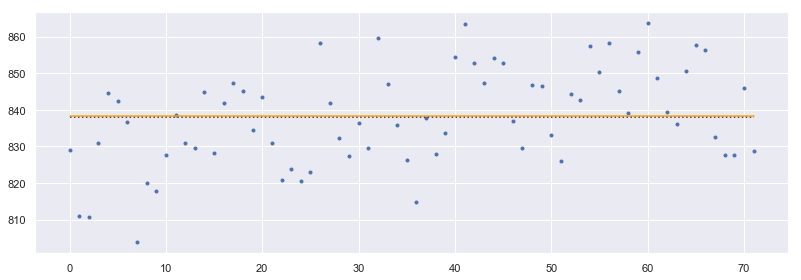

In [10]:
diffs = m1_azi_avg - m1_azi_avg_2
print diffs[0:10]/61.79

fourier_fit = np.empty(72)
fourier_fit[:] = m1_azi_avg[0]/61.79
weighted_fit = np.empty(72)
weighted_fit[:] = m1_azi_avg_2[0]/61.79

fig, ax = plt.subplots(1,1)
plt.sca(ax)
plt.plot(vtr_df[stm_list].iloc[0].values/61.79, '.')
plt.plot(fourier_fit, ':', color='navy')
plt.plot(weighted_fit, '-', color='orange')

fig.tight_layout()
fig.set_size_inches(12,4)

tr,m1:
	Weighted average of all station-trolley baselines with a posteri station extent: 838.1811


trfp/analysis.py:94: RuntimeWarning: invalid value encountered in double_scalars
  baseline_time[st] = sum(out_df.index.values)/summed_pts[st]


tr,m1:
	Weighted average of all station-trolley baselines with a posteri station extent: nan


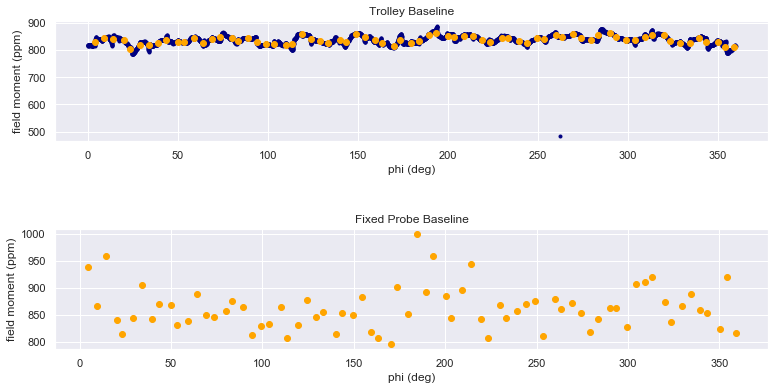

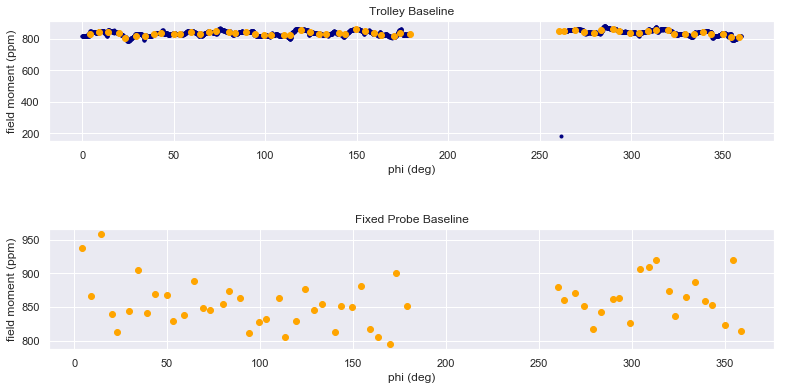

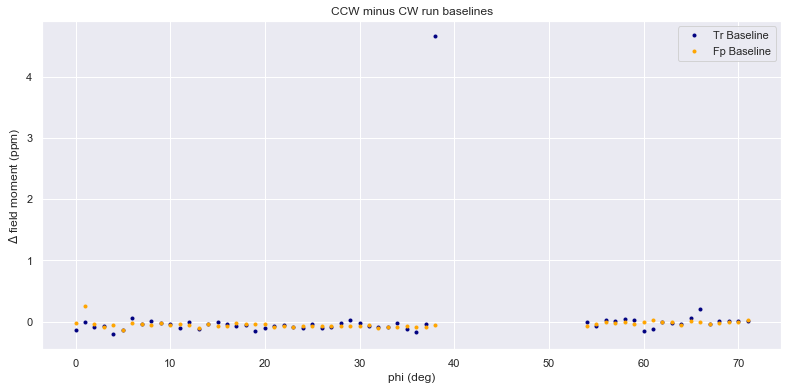

In [11]:
corrected_df = pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3956_corrected_df')
tr_baseline_1, fp_baseline_1, baseline_time_1, summed_azimuth_1, _ = trfp.trolley_run_station_average(corrected_df)

m = 1
trolley_moment = 'tr,m'+str(m)

fig2, ax2 = plt.subplots(2,1)
plt.sca(ax2[0])
plt.plot(corrected_df['tr_phi'],corrected_df[trolley_moment]/61.79, '.', color='navy')
plt.plot(station_phi, tr_baseline_1[:,m-1]/61.79, '.', color='orange', markersize=12)
ax2[0].set_xlabel('phi (deg)')
ax2[0].set_ylabel('field moment (ppm)')
ax2[0].set_title('Trolley Baseline')
plt.sca(ax2[1])
plt.plot(station_phi, fp_baseline_1[:,m-1]/61.79, '.', color='orange', markersize=12)
ax2[1].set_xlabel('phi (deg)')
ax2[1].set_ylabel('field moment (ppm)')
ax2[1].set_title('Fixed Probe Baseline')

fig2.tight_layout()
fig2.set_size_inches(12,6)

print trolley_moment+':'
baseline_mean = sum(summed_azimuth_1*tr_baseline_1[:,m-1])/sum(summed_azimuth_1)
print '\tWeighted average of all station-trolley baselines with a posteri station extent: %0.4f'%(baseline_mean/61.79)

corrected_df = pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3957_corrected_df')
tr_baseline_2, fp_baseline_2, baseline_time_2, summed_azimuth_2, _ = trfp.trolley_run_station_average(corrected_df)

m = 1
trolley_moment = 'tr,m'+str(m)

fig3, ax3 = plt.subplots(2,1)
plt.sca(ax3[0])
plt.plot(corrected_df['tr_phi'],corrected_df[trolley_moment]/61.79, '.', color='navy')
plt.plot(station_phi, tr_baseline_2[:,m-1]/61.79, '.', color='orange', markersize=12)
ax3[0].set_xlabel('phi (deg)')
ax3[0].set_ylabel('field moment (ppm)')
ax3[0].set_title('Trolley Baseline')
plt.sca(ax3[1])
plt.plot(station_phi, fp_baseline_2[:,m-1]/61.79, '.', color='orange', markersize=12)
ax3[1].set_xlabel('phi (deg)')
ax3[1].set_ylabel('field moment (ppm)')
ax3[1].set_title('Fixed Probe Baseline')

fig3.tight_layout()
fig3.set_size_inches(12,6)

print trolley_moment+':'
baseline_mean = sum(summed_azimuth_2*tr_baseline_2[:,m-1])/sum(summed_azimuth_2)
print '\tWeighted average of all station-trolley baselines with a posteri station extent: %0.4f'%(baseline_mean/61.79)

fig4, ax4 = plt.subplots(1,1)
plt.sca(ax4)
plt.plot((tr_baseline_1[:,1]-tr_baseline_2[:,1])/61.79, '.', color = 'navy', label='Tr Baseline')
plt.plot((fp_baseline_1[:,1]-fp_baseline_2[:,1])/61.79, '.', color = 'orange', label='Fp Baseline')
ax4.set_xlabel('phi (deg)')
ax4.set_ylabel(r'$\Delta$ field moment (ppm)')
ax4.set_title('CCW minus CW run baselines')
ax4.legend()
fig4.tight_layout()
fig4.set_size_inches(12,6)

In [2]:
print corrected_df_1['tr,m8'].iloc[0]

NameError: name 'corrected_df_1' is not defined